# Module 1 assigment : MAS Assignment 1

## Description

In the context of the first module of the WASP AI & ML Course, a in-person experiment was performed. In that experiment, people were placed in a large room, asked to wear a labeled colored t-shirt, and instructed to silently and independently position themselves complying to some simple rules (eg. in the middle of your neighbors wearing a yellow t-shirt, next to a t-shirt with label "A"). The overall behaviour appeared to be forcibly convergent, meaning that everyone was willing to break some rules for the sake of getting the task done. This means that decision was non-local, with people waiting each other to avoid collisions, taking into account more than the allowed information (eg. looking to non-immediate neighbors), and ultimately talking out the best strategy. 

## Task


With this assignment we want to eliminate natural human decisions from the experiment and focus on the underlying swarm behaviour. In particular, we want to study two positioning scenarios:
1. always position yourself between A and B;
2. always position yourself so that B is between A and yourself;

under the assumptions:
- the room is free of obstacles;
- each agent uses local decision-making strategies.

Finally, convergence and sensitivity to different parameter settings (eg. perception radius, heterogeneity of speed, limited workspace) are to be analyzed.


## Model


In this simulation, we use mass-less particles in place of humans, and we provide a framework that allows to customize each one of them with different characteristic functions. In this way, the particles follow no specific model, but rather are very general and flexible objects that can be modeled as desired. In particular, one can customize any of the following characteristic:
- _initial position vector_;
- _initial velocity vector_;
- _neighbor selection function_, which specifies how to select neighbors;
- _position calculation policy_, which specifies how to calculate the next position;
- _velocity calculation policy_, which specifies how to calculate the next velocity;
- _particle state space_, which specifies where the particle can be.

In this Python notebook, a number of functions have been already implemented for the sake of running multiple experiments to better illustrate the swarm behaviour. Feel free to create new characteristic functions and try out alternative conditions. 

## Simulator


To reproduce swarm behaviour, we propose a simple Python simulator with very few requirements. In particular, we use NumPy to speed up linear algebra and MatPlotLib to plot the final results. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

def plot(sim_res, repeats=1, title="", ax=None):
    if ax is None:
        ax = plt.axes()
    cmap = cm["hsv"]
    n = sim_res["n"]
    n_reps = n / repeats
    for i in range(n):
        c = cmap((i%n_reps)/n_reps)
        # plot trajectory
        pos = np.array(sim_res["history_pos"][i])
        ax.plot(pos[:, 0], pos[:, 1], color=c)
        # plot final point
        pos = np.array(sim_res["history_pos"][i][-1])
        ax.scatter(pos[0], pos[1], color=c, s=5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)

    # plot termination label
    term = sim_res["termination_code"]
    if term == 0:
        label = "OK"
    elif term == 1:
        label = "IT"
    elif term == 2:
        label = "RNG"
    else:
        label = "??"
    ax.annotate(label,
                xy=(0.0, 1.0), xycoords='axes fraction',
                xytext=(0, 0), textcoords='offset points',
                ha="center", va="center",
                size=10, 
                fontname='Source Code Pro',
                bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"))

def normalize(a, return_norm=False):
    norm = np.linalg.norm(a, axis=-1, keepdims=True)
    b = a.copy() / (norm + (norm == 0))
    if return_norm:
        return b, norm
    return b

In addition, we include video renderings of the simulations using Manim, a popular mathematical visualization tool. This is effortless to install and provides much better final results compared to the static MatPlotLib plots.

In [2]:
import manim
manim.config.verbosity = "WARNING"
manim.config.background_color = manim.WHITE
manim.config.disable_caching = True
manim.config.quality = "low_quality"  # for fast rendering

class HumanSwarm(manim.Scene):
    def construct(self):
        
        ax = manim.Axes(
            x_range=[-4, 4], 
            y_range=[-4, 4],
            x_length = 7, 
            y_length = 7, 
            tips=False
        )
        self.add(ax)

        t = manim.ValueTracker(0)
        
        hp = lambda i : self.sim["history_pos"][i][int(t.get_value())]
        hv = lambda i : self.sim["history_vel"][i][int(t.get_value())]
        hn = lambda i : self.sim["history_neighs"][i][int(t.get_value())]
        
        dots = {}
        for i in range(self.sim["n"]):
            color = manim.utils.color.random_color()
            # moving particle
            dot = manim.always_redraw(
                lambda i=i, color=color : 
                    manim.Dot(point=ax.c2p(*hp(i)), color=color, z_index=1000)
            )
            self.add(dot)
            dots[i] = dot
            # and its velocity
            vel = manim.always_redraw(
                lambda i=i : 
                    manim.Arrow(start=ax.c2p(*hp(i)), end=ax.c2p(*hp(i)) + ax.c2p(*hv(i)))
                        .set_color(dots[i].color)
                        .set_opacity(0.65)
            )
            self.add(vel)
            # and its perception radius
            rad = manim.always_redraw(
                lambda i=i : 
                    manim.AnnularSector(
                        inner_radius=0, 
                        outer_radius=self.pr if not np.isinf(self.pr) else 0, 
                        angle=self.pa * (np.linalg.norm(hv(i)) > 0), 
                        start_angle=-self.pa/2)
                        .set_color(dots[i].color)
                        .set_opacity(0.10)
                        .rotate_about_origin(np.arctan2(*hv(i)[::-1]))
                        .move_arc_center_to(dots[i].get_center())
            )
            self.add(rad)
            # and its trail
            path = manim.VMobject(stroke_color=[color])
            path.set_points_as_corners([dot.get_center(), dot.get_center()])
            path.add_updater(lambda x, d=dot: x.add_points_as_corners([d.get_center()]))
            self.add(path)
            
        for i in range(self.sim["n"]):
            # and its neighbors
            l1 = manim.always_redraw(
                lambda i=i : 
                    manim.Line(start=dots[i].get_center(), end=dots[hn(i)[0]].get_center())
                        .set_color(dots[i].color)
                        .set_opacity(0.45)
            )
            l2 = manim.always_redraw(
                lambda i=i : 
                    manim.Line(start=dots[i].get_center(), end=dots[hn(i)[1]].get_center())
                        .set_color(dots[i].color)
                        .set_opacity(0.45)
            )
            self.add(l1, l2)
        
        frames = self.sim["iterations"]
        self.play(t.animate.set_value(frames-1), run_time=10)

Now we load the `Particle` class, which as clearly stated above does not contain much, but allows for great customization. The `run_simulation` function will be in charge of moving the particles at each time step, until convergence or other termination criteria are reached. In particular, the simulation will stop if all the particles are near to the desired position and their velocity is near zero. Otherwise, a the simulation is stopped when the iterations reach a certain threshold or the particles go beyond a certain distance from the initial baricenter. 

In [3]:
class Particle(object):
    
    def __init__(self, init_pos, init_vel, get_neighbors, get_position, get_velocity, state_space=None, **kwargs):
        super(Particle, self).__init__()
        self.pos = init_pos
        self.vel = init_vel
        self.calculate_neighbors = get_neighbors
        self.calculate_position = get_position
        self.calculate_velocity = get_velocity
        self.limits = state_space if state_space is not None else (lambda pos : pos)
        # check state space
        self.pos = self.limits(self.pos)
        # history
        self.new_pos = None
        self.new_vel = None
        # any other property useful for the specific case
        self.props = kwargs
    
    def compute(self, others):
        # move towards current velocity
        self.new_pos = self.limits(self.pos + self.vel)
        # filter out the neighbors among all the other particles
        neighs = self.calculate_neighbors(self, others)
        # find the desired position using the policy...
        pos_des = self.calculate_position(self, neighs)
        # ... and create the new velocity vector
        self.new_vel = self.calculate_velocity(self, pos_des)
        # return everything new
        return self.new_pos, self.new_vel, neighs
    
    def update(self):
        self.pos = self.new_pos
        self.vel = self.new_vel

def run_simulation(particles, max_iter=3000, term_eps_pos=0.0001, term_eps_vel=0.001, term_radius=10, verbose=False):
    sim_res = {
        "n" : len(particles), 
        "history_pos" : [ [x.pos.copy()] for x in particles ],
        "history_vel" : [ [x.vel.copy()] for x in particles ],
        "history_neighs" : [ [[i, i]] for i in range(len(particles)) ],
        "termination_code" : 0,
        "termination_msg" : "simulation ended smoothly",
        "iterations" : 0
    }
    lookup_particles_index = {p: i for i, p in zip(range(sim_res["n"]), particles)}
    avg_pos = np.mean([p.pos for p in particles], axis=0)
    for it in range(max_iter):
        term_ok = True
        term_bad = False
        # compute next positions and velocities
        for i in range(sim_res["n"]):
            others = [particles[j] for j in range(sim_res["n"]) if j != i]
            new_pos, new_vel, neighs = particles[i].compute(others)
            # save history of each particle
            sim_res["history_pos"][i].append(new_pos)
            sim_res["history_vel"][i].append(new_vel)
            sim_res["history_neighs"][i].append([lookup_particles_index[n] for n in neighs])
        # apply next positions and velocities, and check termination
        for i in range(sim_res["n"]):
            pos_old = particles[i].pos
            particles[i].update()
            pos_new = particles[i].pos
            vel_new = particles[i].vel
            # update termination state
            term_ok &= np.linalg.norm(pos_new - pos_old) < term_eps_pos and np.linalg.norm(vel_new) < term_eps_vel 
            term_bad |= np.linalg.norm(pos_new - avg_pos) > term_radius
        if term_ok:
            break
        if term_bad:
            sim_res["termination_code"] = 2
            sim_res["termination_msg"] = "particles are too far away from center"
            break
    else:
        sim_res["termination_code"] = 1
        sim_res["termination_msg"] = "reached iterations limit"
    # save final iterations
    sim_res["iterations"] = it+1
    # print termination message if requested
    if verbose:
        print(sim["termination_msg"])
    return sim_res

Finally, in the following blocks there are some examples of characteristic functions for the particles. In particular, we provide four neighbor selection policies:
- fixed : each particle sees as neighbors a constant random choice;
- list : each particles has a specific list of neighbors;
- nearest global : each particle sees all the environment and chooses the nearest `k` neighbors;
- nearest radius : each particle sees up to a certain distance from itself and chooses the nearest `k` neighbors;
- nearest cone : each particle sees a cone in the direction it is travelling and chooses the nearest `k` neighbors;

In [4]:
def neighs_policy_fixed(this, others, k=2):
    """ Use randomly selected neighbors. """
    gen = np.random.default_rng(seed=hash(this))
    neighs = gen.choice(others, k, replace=False)
    return neighs.tolist()

def neighs_policy_list(this, others, neighs):
    """ Use provided neighbors. """
    return neighs

def neighs_policy_nearest_global(this, others, k=2):
    """ Filter out the k nearest neighbors. """
    return neighs_policy_nearest_radius(this, others, np.inf, k)

def neighs_policy_nearest_radius(this, others, radius, k=2):
    """ Filter out the k nearest neighbors within the provided radius. """
    dist = [np.linalg.norm(this.pos - x.pos) for x in others]
    best_k_idxs = np.argsort(dist)[:k]
    # filter the indices of the neighbors in the radius, duplicating the node 
    # in the empty buffer spots if needed
    neighs = [others[i] for i in best_k_idxs if dist[i] < radius]
    neighs += [this for _ in range(k - len(neighs))]
    return neighs

def neighs_policy_nearest_cone(this, others, radius, angle, k=2):
    """ Filter out the k nearest neighbors within the provided radius and angle in the velocity direction. """
    pos_rel = np.array([x.pos - this.pos for x in others])
    new_dir = normalize(pos_rel)
    old_dir = normalize(this.vel)
    angle_err = np.arccos(np.clip(np.sum(old_dir * new_dir, axis=-1), -1, +1))
    fov = angle_err <= angle/2
    others_in_fov = [others[i] for i in range(len(others)) if fov[i]]
    
    return neighs_policy_nearest_radius(this, others_in_fov, radius, k)

... the two required positioning policies:
- policy 1 : position yourself between two particles (with this implementation, we position ourselves in the middle between A and B by default);
- policy 2 : position yourself in a line after the other two particles (with this implementation, we position B in the middle between A and ourselves by default);

In [5]:
def position_policy_1(this, neighs, alpha=0.5):
    """ Policy 1: be the man in the middle. """
    pos_des = alpha * neighs[0].pos + (1 - alpha) * neighs[1].pos
    return pos_des

def position_policy_2(this, neighs, scale=1.0, flipped=False):
    """ Policy 2: be the man to the right. """
    # flip the way neighbors are considered
    n0, n1 = neighs[0].pos, neighs[1].pos
    if flipped:
        n0, n1 = n1, n0
    vec = n1 - n0
    dir, norm = normalize(vec, return_norm=True)
    # if scale is integer, then use it as the length between the particles
    # if scale is a float, then use it as percentage for the space between the particles
    vec = scale * (norm if isinstance(scale, float) else 1) * dir
    pos_des = n1 + vec
    return pos_des

... two velocity policies:
- simple : aim towards the desired position with a little amplitude discount;
- constrained : aim towards the desired position with constraints on amplitude increase and steering angle, and a little discount;

In [6]:
def velocity_policy_simple(this, pos_des, discount=0.2):
    pos_err = pos_des - this.pos
    # add a little discount
    return discount * pos_err

def velocity_policy_constr(this, pos_des, max_vel=1.5, max_vel_diff=0.4, max_angle_diff=np.radians(1), discount=0.2):
    pos_err = pos_des - this.pos
    new_dir, new_norm = normalize(pos_err, return_norm=True)
    old_dir, old_norm = normalize(this.vel, return_norm=True)
    # calculate new direction with maximum angle constraint
    if old_norm != 0:
        angle = np.arccos(np.clip(old_dir @ new_dir, -1, +1))  # returns [0, pi]
        axis = np.cross(old_dir, new_dir)
        new_angle = np.sign(axis) * min(angle, max_angle_diff)
        c, s = np.cos(new_angle), np.sin(new_angle)
        new_dir = np.array([[c, -s], [s, c]]) @ old_dir
    # calculate new amplitude with maximum velocity constraint
    sign = np.sign(np.sign(new_norm - old_norm) + .5)  # when sign is 0, force it to 1
    incr = min(max_vel_diff, abs(new_norm - old_norm))
    new_norm = sign * incr + old_norm
    new_norm = min(max_vel, new_norm)
    # glue all together and discount it a little
    vel_new = new_norm * new_dir
    return discount * vel_new

... and two state spaces:
- box : a simple rectangular box around a center (default origin);
- circle : a simple circle around a center (default origin).

In [7]:
def state_space_box(pos, size, center=np.zeros(2)):
    min_y, max_y, min_x, max_x = size
    return center + np.clip(pos - center, [min_x, min_y], [max_x, max_y])

def state_space_circle(pos, radius, center=np.zeros(2)):
    pos_rel = pos - center
    axis, norm = normalize(pos_rel, return_norm=True)
    norm = min(radius, norm)
    pos_rel = norm * axis
    return center + pos_rel

With all these ingredients in place, we are finally able to run some examples and study the behaviour of the system given the various configurations.

## Experiments

### Policy 1

As initial exploration, we start with a simple 3-particles scenario, using Policy 1. We choose the simple velocity policy and fixed neighbors, while the state is unconstrained for every particle. In the plot, each particle has a unique color (if at most 20 partciles are visualized) and each final position is visualized as a dot. In the top-left corner a label reports how the simulation ended: OK if simulation ended successfully, IT if the maximum iterations threshold was reached, RNG if maximum allowed range was exceeded, and ?? if none of the previous apply (this should never happen).

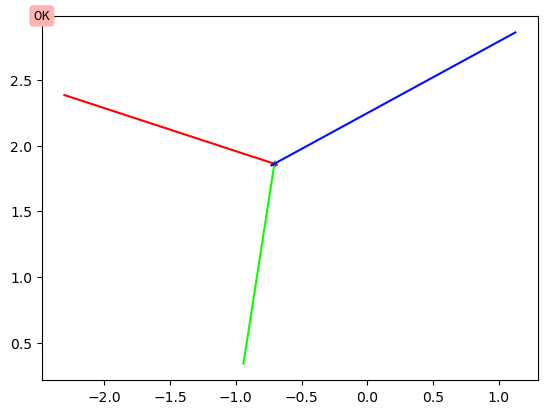

In [8]:
np.random.seed(215688)
N = 3

particles = [Particle(
    init_pos=np.random.uniform(-3.0, +3.0, (2,)),
    init_vel=np.random.uniform(-0.0, +0.0, (2,)),
    get_neighbors=neighs_policy_fixed,
    get_position=position_policy_1,
    get_velocity=velocity_policy_simple
) for _ in range(N)]

res = run_simulation(particles)
plot(res)

To see the evolution of the particles, we resort to the Manim library. To do so, simply run the code below (for all the following examples, the renderings are already available, so there is no need to run again the blocks). In the animation, each particle shows a link to its neighbors and its current velocity vector. Colors will be different from the static plot.

In [9]:
%%manim Swarm1
class Swarm1(HumanSwarm):
    def setup(self):
        self.sim, self.pr, self.pa = res, 0, 2*np.pi

Manim Community v0.18.1

Clearly, as we change the initial velocity of a particle, its behaviour changes. This is due to the fact that the velocity is applyed immediately at each computation, storing the new calculated one for the next step.

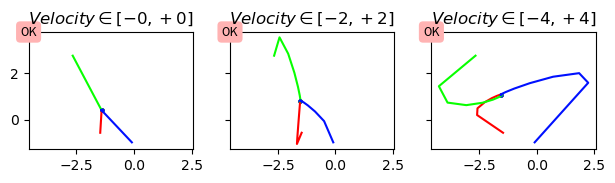

In [10]:
np.random.seed(132463)
N = 3

p = np.random.uniform(-3.0, +3.0, (2,N))

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.tight_layout()
p1 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-0.0, +0.0, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=velocity_policy_simple) for i in range(N)]
p2 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-1.5, +1.5, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=velocity_policy_simple) for i in range(N)]
p3 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-3.0, +3.0, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=velocity_policy_simple) for i in range(N)]
r1 = run_simulation(p1)
r2 = run_simulation(p2)
r3 = run_simulation(p3)
plot(r1, title=r"$Velocity \in [-0,+0]$", ax=ax[0])
plot(r2, title=r"$Velocity \in [-2,+2]$", ax=ax[1])
plot(r3, title=r"$Velocity \in [-4,+4]$", ax=ax[2])

We now restrict the way the velocity can change, using the `velocity_policy_constr` function. Here we allow for a maximum of 0.25 difference in velocity amplitute and 15deg in velocity angle, while constraining the velocity to be below 10. These constraints help adding some realistic behaviour to the particles, which now follow a more gentle and natural-looking trajectory.

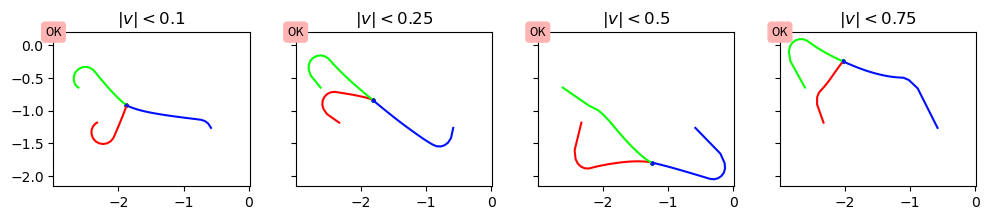

In [11]:
np.random.seed(332463)
N = 3

p = np.random.uniform(-3.0, +3.0, (2,N))
vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.25, max_angle_diff=np.radians(20))

fig, ax = plt.subplots(1, 4, figsize=(10, 20), sharex=True, sharey=True)
fig.tight_layout()
p1 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-0.1, +0.1, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=vel) for i in range(N)]
p2 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-0.25, +0.25, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=vel) for i in range(N)]
p3 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-0.5, +0.5, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=vel) for i in range(N)]
p4 = [Particle(init_pos=p[:,i], init_vel=np.random.uniform(-0.75, +0.75, (2,)), get_neighbors=neighs_policy_fixed, get_position=position_policy_1, get_velocity=vel) for i in range(N)]
r1 = run_simulation(p1)
r2 = run_simulation(p2)
r3 = run_simulation(p3)
r4 = run_simulation(p4)
plot(r1, title=r"$|v| < 0.1$", ax=ax[0])
plot(r2, title=r"$|v| < 0.25$", ax=ax[1])
plot(r3, title=r"$|v| < 0.5$", ax=ax[2])
plot(r4, title=r"$|v| < 0.75$", ax=ax[3])

Regardless of the initial velocity and position, the system appears to be always convergent. This is rather obvious, since the particles want to position themselves in the middle of the other two particles, which clearly resolves into a behavious that brings them all together. This happens even with more than three particles, even with different neighbor functions (below we use `neighs_policy_nearest_global`). In fact, changing how neighbors are selected adds a clustering behaviour, which makes particles converge in more than one point. Although obvious, analytically prove convergence and identification of the equilibriums is an intractable problem in the general case.

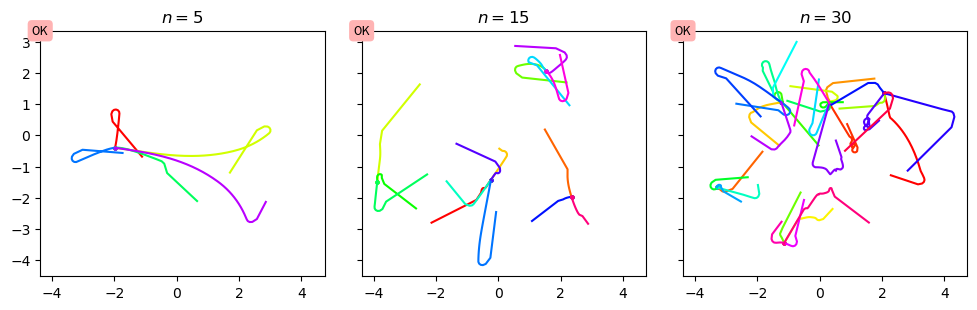

In [12]:
np.random.seed(655321)

vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.25, max_angle_diff=np.radians(30))

fig, ax = plt.subplots(1, 3, figsize=(10, 20), sharex=True, sharey=True)
fig.tight_layout()
p1 = [Particle(init_pos=np.random.uniform(-3.0, +3.0, (2,)), init_vel=np.random.uniform(-1.5, +1.5, (2,)), get_neighbors=neighs_policy_nearest_global, get_position=position_policy_1, get_velocity=vel) for i in range(5)]
p2 = [Particle(init_pos=np.random.uniform(-3.0, +3.0, (2,)), init_vel=np.random.uniform(-1.5, +1.5, (2,)), get_neighbors=neighs_policy_nearest_global, get_position=position_policy_1, get_velocity=vel) for i in range(15)]
p3 = [Particle(init_pos=np.random.uniform(-3.0, +3.0, (2,)), init_vel=np.random.uniform(-1.5, +1.5, (2,)), get_neighbors=neighs_policy_nearest_global, get_position=position_policy_1, get_velocity=vel) for i in range(30)]
r1 = run_simulation(p1)
r2 = run_simulation(p2)
r3 = run_simulation(p3)
plot(r1, title=r"$n = 5$", ax=ax[0])
plot(r2, title=r"$n = 15$", ax=ax[1])
plot(r3, title=r"$n = 30$", ax=ax[2])

Convergence will also not always be reached in the form of an equilibrium point, but it can also appear as a limit cycle. This happens for example when a group of particles tries to reach each other with an unfortunate combination of speed and maximum steering angle. In these cases, the simulator runs up to the maximum iterations number, and then simply stops.

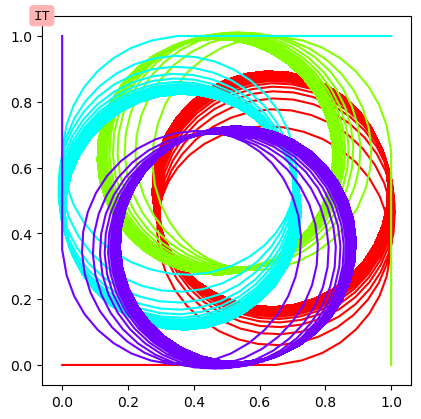

In [13]:
np.random.seed(998276)

x = 1.0  # initial coordinate
v = 0.5  # initial speed
a = 10   # maximum angle

vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.25, max_angle_diff=np.radians(a))

particles = [
    Particle(init_pos=np.array([0.,0.]), init_vel=np.array([ v,0.]),
             get_neighbors=None, get_position=position_policy_1, get_velocity=vel), 
    Particle(init_pos=np.array([ x,0.]), init_vel=np.array([ 0.,v]),
             get_neighbors=None, get_position=position_policy_1, get_velocity=vel), 
    Particle(init_pos=np.array([ x, x]), init_vel=np.array([-v,0.]),
             get_neighbors=None, get_position=position_policy_1, get_velocity=vel), 
    Particle(init_pos=np.array([0., x]), init_vel=np.array([0.,-v]),
             get_neighbors=None, get_position=position_policy_1, get_velocity=vel)]
particles[0].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[1], particles[1]])
particles[1].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[2], particles[2]])
particles[2].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[3], particles[3]])
particles[3].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[0], particles[0]])

r = run_simulation(particles)
plot(r)

### Policy 2

Now, we start to explore the second policy, still starting with a simple scenario. Convergence of this policy is strongly related to the order in which neighbors are found, since their relative position directly influences the output of the positioning policy. This behaviour never appeared with the first policy because each particle was simply aiming for a point bounded between the positions of its neighbors, while now the neighbors are "projecting" each particle onto one of the two semi-segments of the line passing through them, changing drastically the direction of the particle.

To better illustrate the behaviour explained above, we will distinguish two modes for the policy: normal (neighbors are used in their order) and flipped (neighbors are used in reverse). We place the particles around a circumpherence centered at the origin, and equip them with a specific list policy neighbors, so to create a cyclic chase. This means that every particle on the circumpherence will see as its neighbors the first two particles found by starting at the particle's position and following the circumpherence in a counter clockwise fashion. We set each initial velocity to zero and use the simple velocity policy. The positioning policy is then studied in its two modes: on the first row, we can see the normal case, while in the second row the flipped case.

We immediately see that the particles have a mixed behaviour in the first row (normal chase), while they are always diverging in the second row (flipped chase). Let's analyse the second row first. As we can see, the flipped policy places the desired next position in such a way that the next velocity pushes the particles outside the initial spanned region. This clearly creates a expanding spiraling motion, resulting in a divergent behaviour. Switching to the first row now, we can see instead that due to the desired next position being "on the other side", each particle is drawn towards the center of the initial spanned region, resulting in a shrinking spiraling motion that ultimately converges. Finally, let's address the three-particles scenario, which results in a diverging behaviour regardless of the neighbor ordering. In general, these scenarios will always produce the same trajectories, just with different chirality. In fact, the symmetry of the equilateral triangle renders the neighbors other totally ignorable in this case, making the converges of the system rely solely on the combination of speed angle (not a concern in this example, since we are using the simple velocity policy) and amount (our actual problem). In both rows, the velocity has been set with a discount of 0.2, which makes the particles travel only 20% of the calculated error. This again results in movements that push the particles outside the initial region, resulting in a divergent behaviour. If we set a discount of 0.1, both the three-particles systems become convergent. However, changing the discount factor only modifies this particular system, while keeping diverging all the other divergent ones for the same reasons stated above.

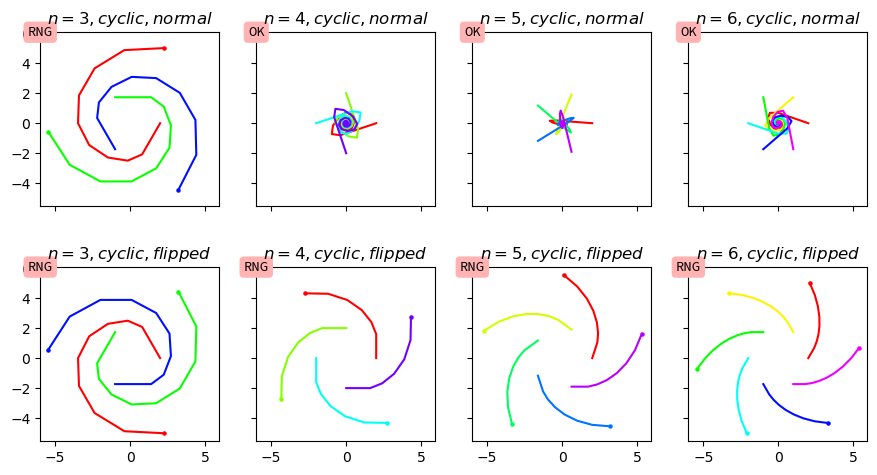

In [48]:
np.random.seed(621763)

n = 3  # initial number of particles
pos = lambda i, n : 2*np.array([np.cos(i/n*2*np.pi), np.sin(i/n*2*np.pi)])
vel = np.zeros((2,))
pol_vel = lambda x, dx : velocity_policy_simple(x, dx, discount=0.2)  # try setting this to 0.05
pol_neighs = lambda x, y, j, p: neighs_policy_list(x, y, [p[(j+1)%len(p)], p[(j+2)%len(p)]])

N = 3  # number of extra particles starting by n
fig, ax = plt.subplots(2, N+1, figsize=(9, 5), sharex=True, sharey=True)
fig.tight_layout()

pol_pos = lambda x, o : position_policy_2(x, o, flipped=False)
for i in range(N+1):
    particles = [Particle(init_pos=pos(j, n+i), init_vel=vel, get_neighbors=None, get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    for j in range(n+i):
        particles[j].calculate_neighbors = lambda x, y, j=j, p=particles : pol_neighs(x, y, j, p)
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {n+i}, cyclic, normal$", ax=ax[0,i])

pol_pos = lambda x, o : position_policy_2(x, o, flipped=True)
for i in range(N+1):
    particles = [Particle(init_pos=pos(j, n+i), init_vel=vel, get_neighbors=None, get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    for j in range(n+i):
        particles[j].calculate_neighbors = lambda x, y, j=j, p=particles : pol_neighs(x, y, j, p)
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {n+i}, cyclic, flipped$", ax=ax[1,i])

Let us now relax the constraints on the initial position by randomly placing the particles in the space and using the nearest neighbors policy with a global perception radius. We also involve the constrained velocity policy. Again, we see very different behaviour based on initial position, initial speed, maximum steering, but particularly on flipping direction. In the first row we can see flipped mode, which 

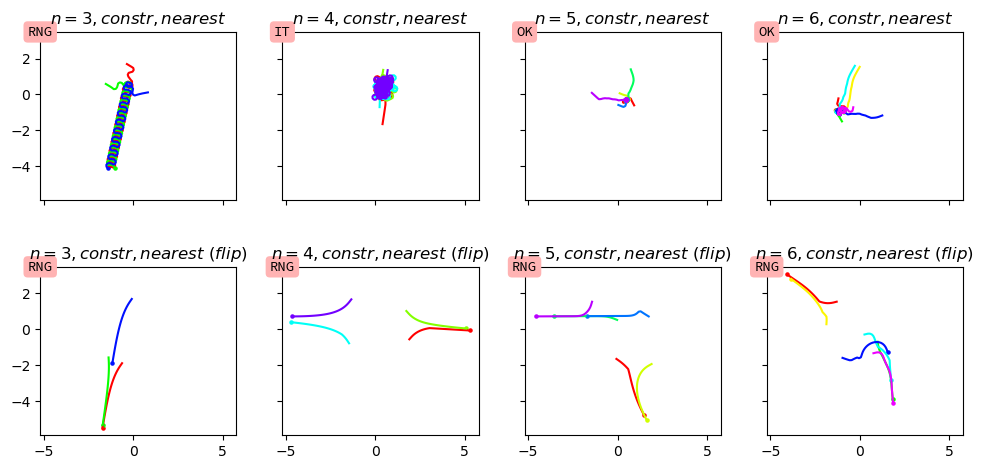

In [49]:
np.random.seed(621763)

n = 3  # initial number of particles
vel = np.zeros((2,))
pol_vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.45, max_angle_diff=np.radians(45))

N = 3  # number of extra particles starting by n
fig, ax = plt.subplots(2, N+1, figsize=(10, 5), sharex=True, sharey=True)
fig.tight_layout()

# n = {3,4,5}, constr velocity, nearest neighbors
pol_pos = lambda x, xd : position_policy_2(x, xd, flipped=False)
for i in range(N+1):
    particles = [Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=vel, get_neighbors=neighs_policy_nearest_global, get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {3+i}, constr, nearest$", ax=ax[0,i])
    
# n = {3,4,5}, constr velocity, nearest neighbors flipped
pol_pos = lambda x, xd : position_policy_2(x, xd, flipped=True)
for i in range(N+1):
    particles = [Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=vel, get_neighbors=neighs_policy_nearest_global, get_position=pol_pos, get_velocity=pol_vel) for j in range(n+i)]
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {3+i}, constr, nearest\ (flip)$", ax=ax[1,i])

Eventually, even that simple case can be rendered divergent if we use a different neighbor policy, like the `neighs_policy_nearest_global`. This is easily explained by observing that the particles enter a neverending chase that finally reached the termination radius. Again, even in this chasing situations, we can still observe clusters of particles aiming towards different directions. Here we show configurations of 3, 5 and 7 particles using the list and nearest neighbors policies, while the last row uses a different velocity policy.

In [43]:
# n = {3,5,7}, simple velocity, nearest neighbors
for i in range(N):
    particles = [Particle(init_pos=pos[:,j], init_vel=np.zeros((2,)), get_neighbors=neighs_policy_nearest_global, get_position=position_policy_2, get_velocity=velocity_policy_simple) for j in range(3+2*i)]
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {3+2*i}, nearest, simple$", ax=ax[1,i])
# n = {3,5,7}, simple velocity, nearest neighbors, flipped
for i in range(N):
    particles = [Particle(init_pos=pos[:,j], init_vel=np.zeros((2,)), get_neighbors=neighs_policy_nearest_global, get_position=lambda x, n : position_policy_2(x, n, flipped=True), get_velocity=velocity_policy_simple) for j in range(3+2*i)]
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {3+2*i}, nearest, simple$", ax=ax[2,i])
# n = {3,5,7}, constrained velocity, nearest neighbors
for i in range(N):
    particles = [Particle(init_pos=pos[:,j], init_vel=np.random.uniform(-1.5, +1.5, (2,)), get_neighbors=neighs_policy_nearest_global, get_position=position_policy_2, get_velocity=vel) for j in range(3+2*i)]
    r = run_simulation(particles, term_radius=5)
    plot(r, title=rf"$n = {3+2*i}, nearest, constr$", ax=ax[3,i])

IndexError: index 6 is out of bounds for axis 1 with size 6

### Mixing policies

With the provided functions, we might also reproduce the "word creation" scenario. By fixing for each particle the right neighbors, meaning that particles in the middle of the word use `position_policy_1` while particles at the beginning and end use `position_policy_2`, we can obtain a simulation that aligns all the particles in a straight line. The space between the particles can be set by modifying the default parameter in the policy functions.

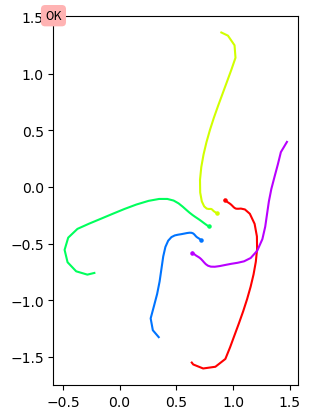

In [39]:
np.random.seed(998476)

vel = lambda x, d : velocity_policy_constr(x, d, max_vel=10.0, max_vel_diff=0.45, max_angle_diff=np.radians(30))

particles = [
    Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=np.random.uniform(-0.1, +0.1, (2,)), get_neighbors=None, get_position=position_policy_2, get_velocity=vel), 
    Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=np.random.uniform(-0.1, +0.1, (2,)), get_neighbors=None, get_position=position_policy_1, get_velocity=vel), 
    Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=np.random.uniform(-0.1, +0.1, (2,)), get_neighbors=None, get_position=position_policy_1, get_velocity=vel), 
    Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=np.random.uniform(-0.1, +0.1, (2,)), get_neighbors=None, get_position=position_policy_1, get_velocity=vel), 
    Particle(init_pos=np.random.uniform(-2.0, +2.0, (2,)), init_vel=np.random.uniform(-0.1, +0.1, (2,)), get_neighbors=None, get_position=position_policy_2, get_velocity=vel)
]
particles[0].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[2], particles[1]])
particles[1].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[0], particles[2]])
particles[2].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[1], particles[3]])
particles[3].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[2], particles[4]])
particles[4].calculate_neighbors = lambda x, y : neighs_policy_list(x, y, [particles[2], particles[3]])

r = run_simulation(particles)
plot(r)

In [ ]:
np.random.seed(311227)
N = 30

perception_radius = 3.5
perception_angle = 2/3*np.pi

particles = [Particle(
    init_pos=np.random.uniform(-3.0, +3.0, (2,)),
    init_vel=np.random.uniform(-0.1, 0.1, (2,)),
    get_neighbors=lambda x, y : neighs_policy_nearest_cone(x, y, radius=perception_radius, angle=perception_angle),
    get_position=position_policy_1,
    get_velocity=lambda x, d : velocity_policy_constr(x, d, max_vel=2.5, max_vel_diff=0.9, max_angle_diff=np.radians(30)),
    state_space=lambda x : state_space_box(x, size=(-3, +3, -3, +3))  # bottom, top, left, right
) for _ in range(N)]

run_simulation(particles, max_iter=3000, term_eps_pos=0.0001, term_eps_vel=0.001, term_radius=10)
plot(particles)

In [ ]:
%%manim Swarm1
class Swarm1(HumanSwarm):
    def setup(self):
        self.ps, self.pr, self.pa = particles, 0, perception_angle